# Subreddit Post Sentiment Classification

In [ ]:
# Install Required Libraries

!pip install vaderSentiment
!pip install prettytable

In [ ]:
# Import important Libraries

import nltk
import spacy
import string
import matplotlib
import collections
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from spacy.lang.en import English
from prettytable import PrettyTable 
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# Text pre-processing: remove stop words & punctuations, tokenization, lemmatization and normalization

punctuations = string.punctuation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def spacy_tokenizer(text):
  
    mytokens = parser(text)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

In [ ]:
# Load Data

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")
validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")
test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

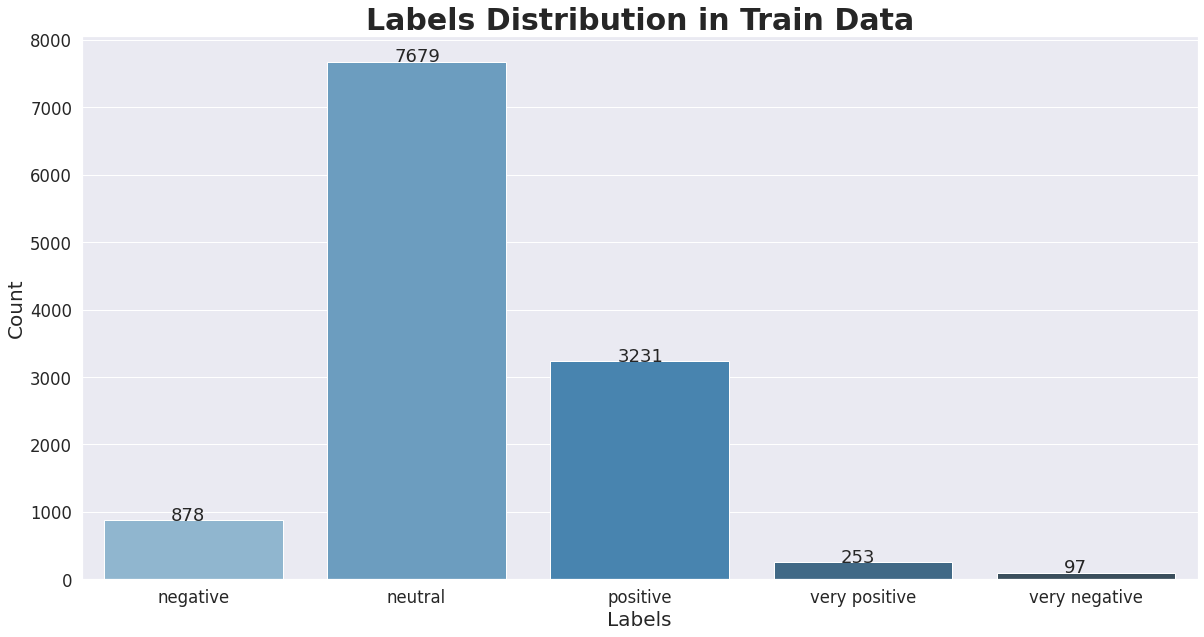

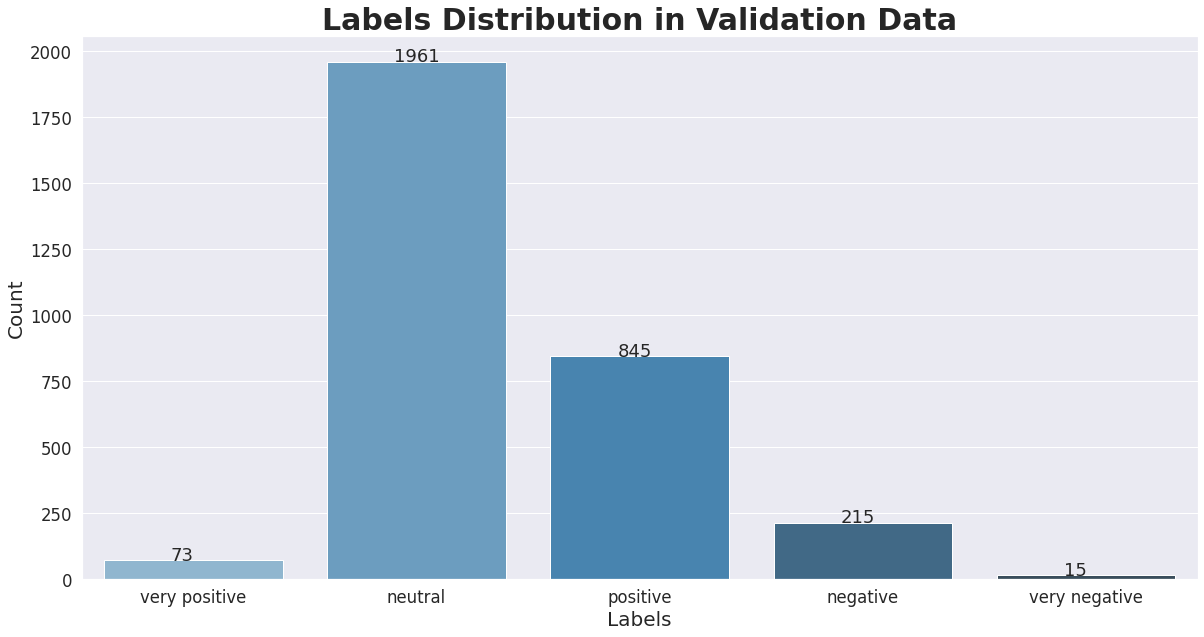

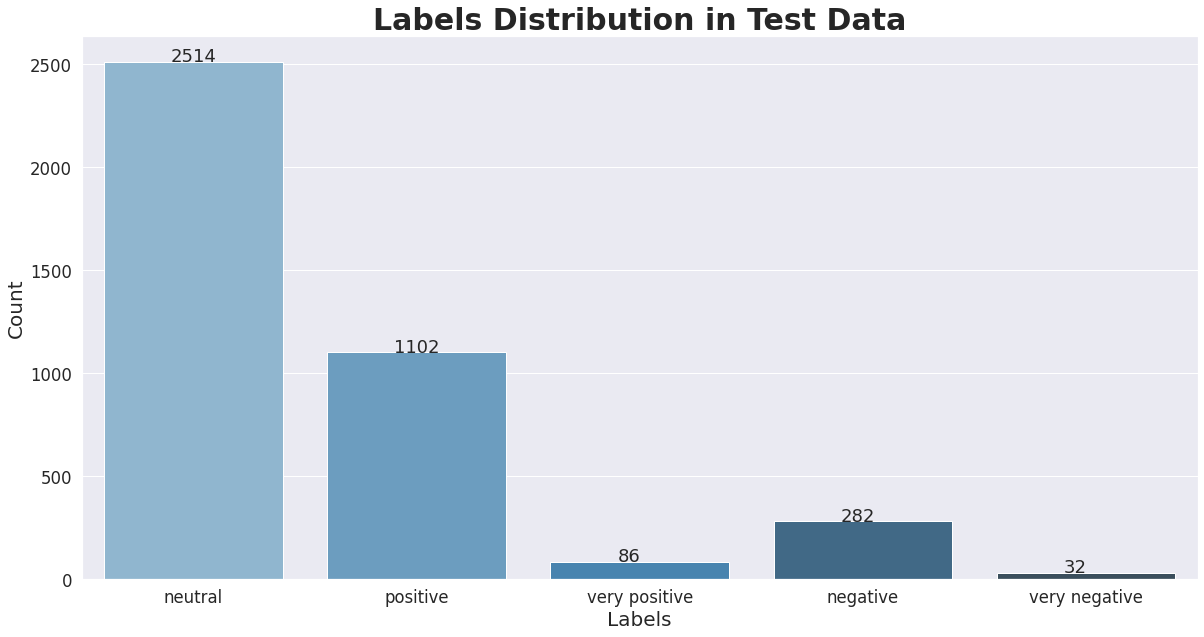

In [ ]:
# Labels Numeric Encoding and Checking Labels Distribution in all three Train, Validation and Test Data

# print("Classes:\n",train_data['sentiment.polarity'].unique(), "\n")

def create_label(x):
    if x == 'negative':
        return 0
    if x == 'neutral':
        return 1
    if x == 'positive':
        return 2
    if x == 'very positive':
        return 3
    if x == 'very negative':
        return 4

train_data['Class'] = train_data['sentiment.polarity'].apply(create_label)
validation_data['Class'] = validation_data['sentiment.polarity'].apply(create_label)
test_data['Class'] = test_data['sentiment.polarity'].apply(create_label)

sns.set(font_scale  = 1.5)
ax = sns.countplot(x = "sentiment.polarity", data = train_data, palette=("Blues_d"))
ax.set_title('Labels Distribution in Train Data', fontweight="bold", size = 30) # Title

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.3, p.get_height()))

ax.set_xlabel('Labels', fontsize=20)    
ax.set_ylabel('Count', fontsize=20)    
plt.gcf().set_size_inches(20, 10) 
plt.show()

sns.set_style("white")

sns.set(font_scale = 1.5)
ax = sns.countplot(x="sentiment.polarity", data = validation_data, palette=("Blues_d"))
ax.set_title('Labels Distribution in Validation Data', fontweight="bold", size = 30) # Title

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.3, p.get_height()))

ax.set_xlabel('Labels', fontsize=20)    
ax.set_ylabel('Count', fontsize=20)    
plt.gcf().set_size_inches(20, 10) 
plt.show()


sns.set(font_scale = 1.5)
ax = sns.countplot(x="sentiment.polarity", data = test_data, palette=("Blues_d"))
ax.set_title('Labels Distribution in Test Data', fontweight="bold", size = 30) # Title

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.3, p.get_height()))

ax.set_xlabel('Labels', fontsize=20)    
ax.set_ylabel('Count', fontsize=20)    
plt.gcf().set_size_inches(20, 10) 
plt.show()

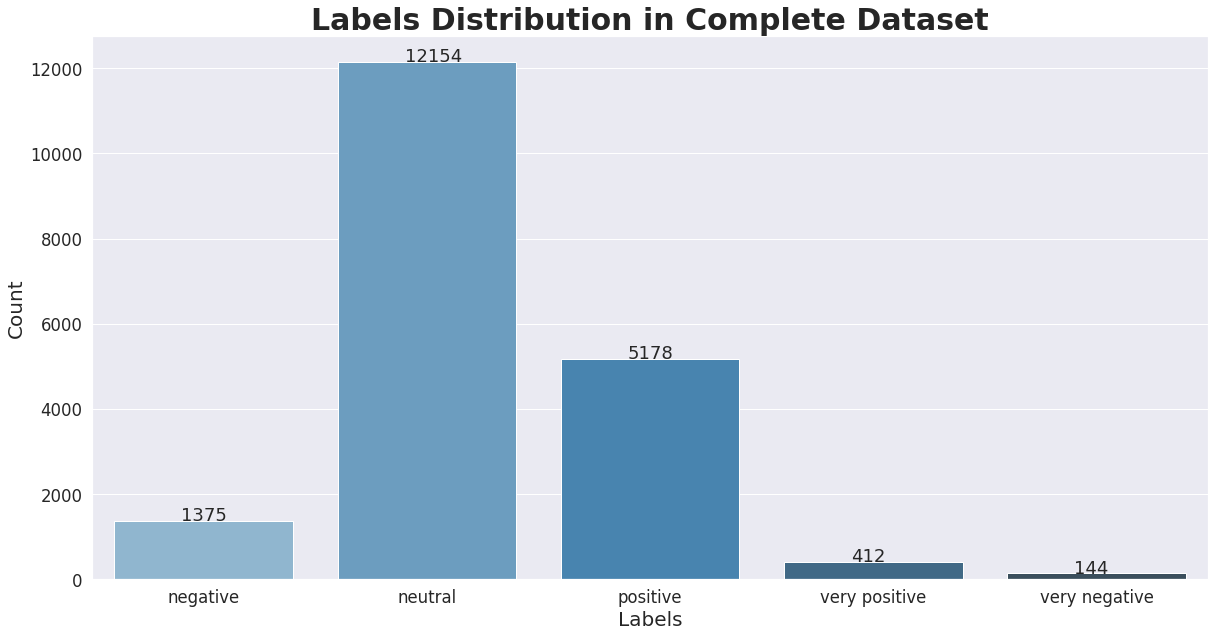

In [ ]:
# Concatinating train, test and validation dataset and removing extra indexes. Also showing graph

train_validation_test = pd.concat([train_data, validation_data, test_data], axis=0)
train_validation_test .reset_index(drop=True, inplace=True)

sns.set(font_scale = 1.5)
ax = sns.countplot(x="sentiment.polarity", data = train_validation_test, palette=("Blues_d"))
ax.set_title('Labels Distribution in Complete Dataset', fontweight="bold", size = 30) # Title

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.3, p.get_height()))

ax.set_xlabel('Labels', fontsize=20)    
ax.set_ylabel('Count', fontsize=20)    
plt.gcf().set_size_inches(20, 10) 
plt.show()


In [ ]:
# Check Labels Distribution in Percentage in all three Train, Validation and Test Data

print("\nTrain Labels Distribution Percentage:\n")
train_label_counts = collections.Counter(train_data['sentiment.polarity'])

for label in train_label_counts:
    print("Label: " + str(label))
    print("{:.2%} ".format(train_label_counts[label] / len(train_data)))
    
print("\nValidation Labels Distribution Percentage:\n")
validation_label_counts = collections.Counter(validation_data['sentiment.polarity'])

for label in validation_label_counts:
    print("Label: " + str(label))
    print("{:.2%} ".format(validation_label_counts[label] / len(validation_data)))

print("\nTest Labels Distribution Percentage:\n")
test_label_counts = collections.Counter(test_data['sentiment.polarity'])

for label in test_label_counts:
    print("Label: " + str(label))
    print("{:.2%} ".format(test_label_counts[label] / len(test_data)))


Train Labels Distribution Percentage:

Label: negative
7.23% 
Label: neutral
63.26% 
Label: positive
26.62% 
Label: very positive
2.08% 
Label: very negative
0.80% 

Validation Labels Distribution Percentage:

Label: very positive
2.35% 
Label: neutral
63.07% 
Label: positive
27.18% 
Label: negative
6.92% 
Label: very negative
0.48% 

Test Labels Distribution Percentage:

Label: neutral
62.60% 
Label: positive
27.44% 
Label: very positive
2.14% 
Label: negative
7.02% 
Label: very negative
0.80% 


In [ ]:
# Counting the neutral posts across train, validation and test data

print('Training set contains {:d} posts.'.format(len(train_data)))
print('Validation set contains {:d} posts.'.format(len(validation_data)))
print('Test set contains {:d} posts.'.format(len(test_data)))

number_neutral_train = sum(train_data['Class'] == 1)
number_neutral_validation = sum(validation_data['Class'] == 1)
number_neutral_test = sum(test_data['Class'] == 1)

print('Training set contains %0.0f %% neutral posts' % (100*number_neutral_train/len(train_data)))
print('Validation set contains %0.0f %% neutral posts' % (100*number_neutral_validation/len(validation_data)))
print('Test set contains %0.0f %% neutral posts' % (100*number_neutral_test/len(test_data)))

Training set contains 12138 posts.
Validation set contains 3109 posts.
Test set contains 4016 posts.
Training set contains 63 % neutral posts
Validation set contains 63 % neutral posts
Test set contains 63 % neutral posts


In [ ]:
# Creating labels

train_labels = train_data['Class']
validation_labels = validation_data['Class']
test_labels = test_data['Class']

In [ ]:
# Function that uses the required vectorizer according to argument provided and returns train, validation and test features.

def encoding(type):
    if type == "One-hot":
        vectorizer = CountVectorizer(binary = True)
    else:
        vectorizer = TfidfVectorizer()
    train_features = vectorizer.fit_transform(train_data['body'])
    validation_features = vectorizer.transform(validation_data['body'])
    test_features = vectorizer.transform(test_data['body'])
    return train_features, validation_features, test_features

In [ ]:
# Calling the above function to get train, validation and test features according to One Hot encoding.

train_features, validation_features, test_features = encoding("One-hot")

In [ ]:
# Function to create Evaluation Summary report and Confusion matrix Heatmap

def evaluation_summary(description, predictions, true_labels, return_fun):
    
    if return_fun == True:
        print("Evaluation for: " + description)
        print(classification_report(true_labels, predictions, digits=3, zero_division = 0))
        cr = classification_report(true_labels, predictions, digits=3, zero_division = 0, output_dict=True)
        df_classification_report = pd.DataFrame(cr).transpose()
        return df_classification_report
    else:
        print("Evaluation for: " + description)
        print(classification_report(true_labels, predictions, digits=3, zero_division = 0))

def confusion_matrix_build(description, predictions, true_labels):
    print("Confusion Matrix for: " + description)
    print(sns.heatmap(confusion_matrix(true_labels, predictions), square=True, annot=True, fmt='d', cbar=True))

In [ ]:
# Function to return performance Data of classifiers

def list_builder(es):
  es = es.drop(['support'], axis=1)
  #es = es.drop(["weighted avg"])
  es = es.drop(["0", "1", "2", "3", "4"])
  list_of_list = es.values.tolist()
  flat_list = [item for sublist in list_of_list for item in sublist]
  function_list = []
  function_list.append(flat_list[0])
  function_list.append(flat_list[3])
  function_list.append(flat_list[4])
  function_list.append(flat_list[5])
  function_list.append(flat_list[6])
  function_list.append(flat_list[7])
  function_list.append(flat_list[8])
  function_list = [round(num, 3) for num in function_list]
  return function_list

In [ ]:
# (a) Dummy Classifier with strategy="most_frequent" Performance Report

dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)

es = evaluation_summary("Dummy Classifier with strategy='most_frequent' On Train Set\n", dummy_mf.predict(train_features), train_labels, True)

train_dummy_mf = list_builder(es)

es = evaluation_summary("Dummy Classifier with strategy='most_frequent' On Test Set\n", dummy_mf.predict(test_features), test_labels, True)

test_dummy_mf = list_builder(es)

Evaluation for: Dummy Classifier with strategy='most_frequent' On Train Set

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       878
           1      0.633     1.000     0.775      7679
           2      0.000     0.000     0.000      3231
           3      0.000     0.000     0.000       253
           4      0.000     0.000     0.000        97

    accuracy                          0.633     12138
   macro avg      0.127     0.200     0.155     12138
weighted avg      0.400     0.633     0.490     12138

Evaluation for: Dummy Classifier with strategy='most_frequent' On Test Set

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       282
           1      0.626     1.000     0.770      2514
           2      0.000     0.000     0.000      1102
           3      0.000     0.000     0.000        86
           4      0.000     0.000     0.000        32

    accuracy                    

In [ ]:
# (b) Dummy Classifier with strategy="stratified" Performance Report

dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(train_features, train_labels)

es = evaluation_summary("Dummy Classifier with strategy='stratified' On Train Set\n", dummy_prior.predict(train_features), train_labels, True)

train_dummy_stratified = list_builder(es)

es = evaluation_summary("Dummy Classifier with strategy='stratified' On Test Set\n", dummy_prior.predict(test_features), test_labels, True)

test_dummy_stratified = list_builder(es)

Evaluation for: Dummy Classifier with strategy='stratified' On Train Set

              precision    recall  f1-score   support

           0      0.070     0.071     0.070       878
           1      0.638     0.639     0.639      7679
           2      0.268     0.264     0.266      3231
           3      0.019     0.020     0.019       253
           4      0.020     0.021     0.021        97

    accuracy                          0.480     12138
   macro avg      0.203     0.203     0.203     12138
weighted avg      0.480     0.480     0.480     12138

Evaluation for: Dummy Classifier with strategy='stratified' On Test Set

              precision    recall  f1-score   support

           0      0.095     0.099     0.097       282
           1      0.624     0.634     0.629      2514
           2      0.265     0.254     0.259      1102
           3      0.000     0.000     0.000        86
           4      0.000     0.000     0.000        32

    accuracy                          

In [ ]:
# (c) LogisticRegression with One-hot vectorization Performance Report

lr = LogisticRegression(max_iter=250)
lr_model = lr.fit(train_features, train_labels)

es = evaluation_summary("LogisticRegression with One-hot vectorization On Train Set\n", lr_model.predict(train_features), train_labels, True)

train_lr_onehot = list_builder(es)

es = evaluation_summary("LogisticRegression with One-hot vectorization On Test Set\n", lr_model.predict(test_features), test_labels, True)

test_lr_onehot = list_builder(es)

Evaluation for: LogisticRegression with One-hot vectorization On Train Set

              precision    recall  f1-score   support

           0      0.984     0.868     0.923       878
           1      0.957     0.995     0.976      7679
           2      0.980     0.943     0.961      3231
           3      0.995     0.802     0.888       253
           4      1.000     0.649     0.788        97

    accuracy                          0.965     12138
   macro avg      0.983     0.852     0.907     12138
weighted avg      0.966     0.965     0.965     12138

Evaluation for: LogisticRegression with One-hot vectorization On Test Set

              precision    recall  f1-score   support

           0      0.451     0.230     0.305       282
           1      0.773     0.877     0.822      2514
           2      0.712     0.625     0.666      1102
           3      0.478     0.256     0.333        86
           4      0.800     0.125     0.216        32

    accuracy                      

In [ ]:
# Calling the encoding function to get train, validation and test features according to TF-IDF encoding.

train_features, validation_features, test_features = encoding("TF-IDF")

In [ ]:
# (d) LogisticRegression with TF-IDF vectorization (default settings) Performance Report

lr = LogisticRegression(max_iter=250)
lr_model = lr.fit(train_features, train_labels)

es = evaluation_summary(" LogisticRegression with TF-IDF vectorization On Train Set\n", lr_model.predict(train_features), train_labels, True)

train_lr_tfidf = list_builder(es)

es = evaluation_summary(" LogisticRegression with TF-IDF vectorization On Test Set\n", lr_model.predict(test_features), test_labels, True)

test_lr_tfidf = list_builder(es)

Evaluation for:  LogisticRegression with TF-IDF vectorization On Train Set

              precision    recall  f1-score   support

           0      0.914     0.182     0.304       878
           1      0.795     0.979     0.877      7679
           2      0.894     0.679     0.772      3231
           3      0.979     0.186     0.312       253
           4      1.000     0.021     0.040        97

    accuracy                          0.817     12138
   macro avg      0.916     0.409     0.461     12138
weighted avg      0.835     0.817     0.789     12138

Evaluation for:  LogisticRegression with TF-IDF vectorization On Test Set

              precision    recall  f1-score   support

           0      0.619     0.092     0.160       282
           1      0.736     0.944     0.827      2514
           2      0.758     0.508     0.608      1102
           3      0.778     0.081     0.147        86
           4      0.000     0.000     0.000        32

    accuracy                      

In [ ]:
# Calling the encoding function to get train, validation and test features according to One-hot encoding.

train_features, validation_features, test_features = encoding("One-hot")

In [ ]:
# (e) SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings) Performance Report

model = SVC(kernel = 'rbf')
svc_model = model.fit(train_features, train_labels)
es = evaluation_summary("SVC Classifier with One-hot vectorization (RBF kernel) On Train Set\n", svc_model.predict(train_features), train_labels, True)

train_svc = list_builder(es)

es = evaluation_summary("SVC Classifier with One-hot vectorization (RBF kernel) On Test Set\n", svc_model.predict(test_features), test_labels, True)

test_svc = list_builder(es)

Evaluation for: SVC Classifier with One-hot vectorization (RBF kernel) On Train Set

              precision    recall  f1-score   support

           0      0.992     0.289     0.448       878
           1      0.840     0.988     0.908      7679
           2      0.921     0.811     0.862      3231
           3      1.000     0.036     0.069       253
           4      0.000     0.000     0.000        97

    accuracy                          0.862     12138
   macro avg      0.751     0.425     0.457     12138
weighted avg      0.869     0.862     0.838     12138

Evaluation for: SVC Classifier with One-hot vectorization (RBF kernel) On Test Set

              precision    recall  f1-score   support

           0      0.800     0.014     0.028       282
           1      0.720     0.957     0.822      2514
           2      0.769     0.466     0.581      1102
           3      0.000     0.000     0.000        86
           4      0.000     0.000     0.000        32

    accuracy    

In [ ]:
# One hot vectorization with appropriate pre-processing

def manual_encoding():

    vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, binary = True)

    train_features = vectorizer.fit_transform(train_data['body'])
    validation_features = vectorizer.transform(validation_data['body'])
    test_features = vectorizer.transform(test_data['body'])
    return train_features, validation_features, test_features

manual_train_features, manual_validation_features, manual_test_features = manual_encoding()

In [ ]:
#(f) MLP classifier model Performance Report

classifier = MLPClassifier(alpha = 0.1, max_iter = 200) 
classifier.fit(manual_train_features, train_labels)

es = evaluation_summary("Multi-layer Perceptron with One-hot vectorization On Train Set\n", classifier.predict(manual_train_features), train_labels, True)

train_mlp = list_builder(es)

es = evaluation_summary("Multi-layer Perceptron with One-hot vectorization On Test Set\n", classifier.predict(manual_test_features), test_labels, True)
es_copy = es.copy(deep=True)
test_mlp = list_builder(es)

es_copy = es_copy.drop(['support', 'recall', 'precision'], axis=1)
es_copy = es_copy.drop(["accuracy", "macro avg", "weighted avg"])
index_ = ['negative', 'neutral', 'positive', 'very positive', 'very negative']
es_copy['index'] = index_
roundThree = es_copy['f1-score'].round(decimals=3)
es_copy['f1-score'] = roundThree

Evaluation for: Multi-layer Perceptron with One-hot vectorization On Train Set

              precision    recall  f1-score   support

           0      1.000     0.994     0.997       878
           1      0.996     0.999     0.998      7679
           2      0.997     0.993     0.995      3231
           3      0.996     0.988     0.992       253
           4      1.000     0.979     0.990        97

    accuracy                          0.997     12138
   macro avg      0.998     0.991     0.994     12138
weighted avg      0.997     0.997     0.997     12138

Evaluation for: Multi-layer Perceptron with One-hot vectorization On Test Set

              precision    recall  f1-score   support

           0      0.505     0.390     0.440       282
           1      0.794     0.857     0.824      2514
           2      0.705     0.634     0.668      1102
           3      0.562     0.477     0.516        86
           4      0.737     0.438     0.549        32

    accuracy              

In [ ]:
# The overall results obtained by the classifiers on the training and test sets in one table, and highlighted the best performance.

class ConsoleColor:
    # Color
    BLACK = '\033[90m'
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    GRAY = '\033[97m'

    # Style
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

    # BackgroundColor
    BgBLACK = '\033[40m'
    BgRED = '\033[41m'
    BgGREEN = '\033[42m'
    BgORANGE = '\033[43m'
    BgBLUE = '\033[44m'
    BgPURPLE = '\033[45m'
    BgCYAN = '\033[46m'
    BgGRAY = '\033[47m'

    # End
    END = '\033[0m'

print("Overall Results")

comparison_table = PrettyTable(["Result", "Accuracy", "Precision Macro Avg", "Recall Macro Avg", "F1_Score Macro Avg", "Precision Weighted Avg", "Recall Weighted Avg", "F1_Score Weighted Avg"]) 
comparison_table.add_row(["dummy_mf_train",train_dummy_mf[0],train_dummy_mf[1],train_dummy_mf[2],train_dummy_mf[3],train_dummy_mf[4],train_dummy_mf[5],train_dummy_mf[6]])
comparison_table.add_row(["dummy_mf_test",test_dummy_mf[0],test_dummy_mf[1],test_dummy_mf[2],test_dummy_mf[3],test_dummy_mf[4],test_dummy_mf[5],test_dummy_mf[6]])
comparison_table.add_row(["dummy_stratified_train",train_dummy_stratified[0],train_dummy_stratified[1],train_dummy_stratified[2],train_dummy_stratified[3],train_dummy_stratified[4],train_dummy_stratified[5],train_dummy_stratified[6]])
comparison_table.add_row(["dummy_stratified_test",test_dummy_stratified[0],test_dummy_stratified[1],test_dummy_stratified[2],test_dummy_stratified[3],test_dummy_stratified[4],test_dummy_stratified[5],test_dummy_stratified[6]])
comparison_table.add_row(["lr_onehot_train",train_lr_onehot[0],train_lr_onehot[1],train_lr_onehot[2],train_lr_onehot[3],train_lr_onehot[4],train_lr_onehot[5],train_lr_onehot[6]])
comparison_table.add_row(["lr_onehot_test",test_lr_onehot[0],test_lr_onehot[1],test_lr_onehot[2],test_lr_onehot[3],test_lr_onehot[4],test_lr_onehot[5],test_lr_onehot[6]])
comparison_table.add_row(["lr_tfidf_train",train_lr_tfidf[0],train_lr_tfidf[1],train_lr_tfidf[2],train_lr_tfidf[3],train_lr_tfidf[4],train_lr_tfidf[5],train_lr_tfidf[6]])
comparison_table.add_row(["lr_tfidf_test",test_lr_tfidf[0],test_lr_tfidf[1],test_lr_tfidf[2],test_lr_tfidf[3],test_lr_tfidf[4],test_lr_tfidf[5],test_lr_tfidf[6]])
comparison_table.add_row(["svc_train",train_svc[0],train_svc[1],train_svc[2],train_svc[3],train_svc[4],train_svc[5],train_svc[6]])
comparison_table.add_row(["svc_test",test_svc[0],test_svc[1],test_svc[2],test_svc[3],test_svc[4],test_svc[5],test_svc[6]])
comparison_table.add_row(["mlp_train",train_mlp[0],train_mlp[1],train_mlp[2],train_mlp[3],train_mlp[4],train_mlp[5],train_mlp[6]])
comparison_table.add_row([ConsoleColor.BOLD + "\033[40m \033[97m mlp_test" + ConsoleColor.END,test_mlp[0],test_mlp[1],test_mlp[2],test_mlp[3],test_mlp[4],test_mlp[5],test_mlp[6]])

print(comparison_table)

Overall Results
+------------------------+----------+---------------------+------------------+--------------------+------------------------+---------------------+-----------------------+
|         Result         | Accuracy | Precision Macro Avg | Recall Macro Avg | F1_Score Macro Avg | Precision Weighted Avg | Recall Weighted Avg | F1_Score Weighted Avg |
+------------------------+----------+---------------------+------------------+--------------------+------------------------+---------------------+-----------------------+
|     dummy_mf_train     |  0.633   |        0.127        |       0.2        |       0.155        |          0.4           |        0.633        |          0.49         |
|     dummy_mf_test      |  0.626   |        0.125        |       0.2        |       0.154        |         0.392          |        0.626        |         0.482         |
| dummy_stratified_train |   0.48   |        0.203        |      0.203       |       0.203        |          0.48          |     

Confusion Matrix for: Multi-layer Perceptron with One-hot vectorization On Test Set

AxesSubplot(0.241667,0.125;0.503333x0.755)


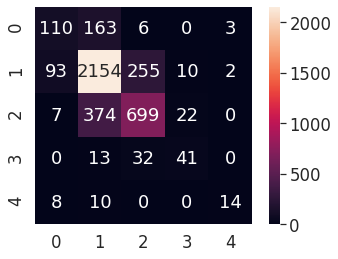

In [ ]:
# Confusion Matrix for Best Classifier (MLP)

confusion_matrix_build("Multi-layer Perceptron with One-hot vectorization On Test Set\n", classifier.predict(manual_test_features), test_labels)

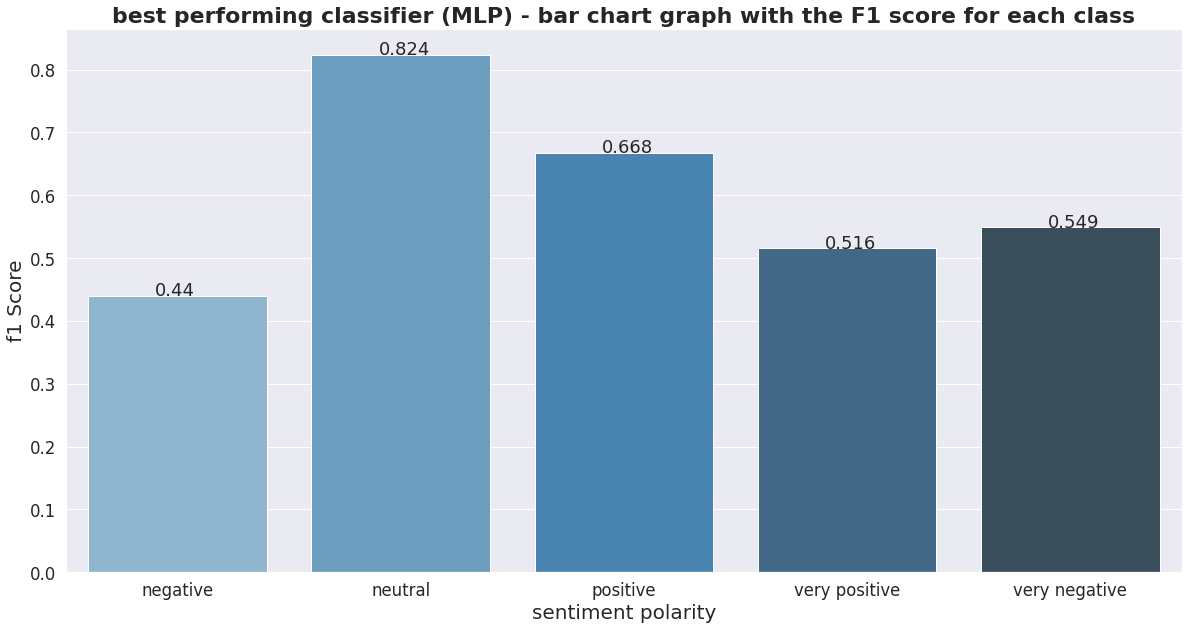

In [ ]:
# The best performing classifier - bar chart graph with the F1 score for each class - (sentiment polarity labels on x-axis, F1 score on Y axis).

sns.set(font_scale = 1.5)
ax = sns.barplot(data = es_copy
            ,y = 'f1-score'
            ,x = 'index', palette=("Blues_d")
            )
ax.set_title('best performing classifier (MLP) - bar chart graph with the F1 score for each class', fontweight="bold", size = 22) # Title

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.3, p.get_height()))

ax.set_xlabel('sentiment polarity', fontsize=20)    
ax.set_ylabel('f1 Score', fontsize=20)    
plt.gcf().set_size_inches(20, 10) 
plt.show()

# Q2

In [ ]:
# Calling the encoding function to get train, validation and test features according to TF-IDF encoding.

train_features, validation_features, test_features = encoding("TF-IDF")

In [ ]:
# Class initilization

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y = None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
#Creating Pipeline

prediction_pipeline = Pipeline([
              ('lr', LogisticRegression(solver='lbfgs', max_iter = 5000))
              ])

prediction_pipeline.fit(train_features, train_labels)

evaluation_summary("LogisticRegression with TF-IDF vectorization (max_features)\n", prediction_pipeline.predict(validation_features), validation_labels, False)

Evaluation for: LogisticRegression with TF-IDF vectorization (max_features)

              precision    recall  f1-score   support

           0      0.581     0.084     0.146       215
           1      0.732     0.938     0.823      1961
           2      0.731     0.482     0.581       845
           3      0.778     0.096     0.171        73
           4      0.000     0.000     0.000        15

    accuracy                          0.731      3109
   macro avg      0.564     0.320     0.344      3109
weighted avg      0.719     0.731     0.691      3109



In [ ]:
# Parameter selection using GridSearchCV

params = {
   'lr__solver': ("lbfgs", "sag", "saga", "newton-cg"), 
}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1, scoring='f1_weighted', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(train_features, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)

print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['lr']
parameters:
{'lr__solver': ('lbfgs', 'sag', 'saga', 'newton-cg')}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.6s finished


Best score: 0.654
Best parameters set:
	lr__solver: 'saga'


In [ ]:
#Creating Pipeline

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = False)),
              ('lr', LogisticRegression(solver='saga', max_iter = 5000))
              ])

prediction_pipeline.fit(train_data, train_labels)

evaluation_summary("LogisticRegression with TF-IDF vectorization (sublinear_tf)\n", prediction_pipeline.predict(validation_data), validation_labels, False)

Evaluation for: LogisticRegression with TF-IDF vectorization (sublinear_tf)

              precision    recall  f1-score   support

           0      0.581     0.084     0.146       215
           1      0.732     0.938     0.823      1961
           2      0.731     0.482     0.581       845
           3      0.778     0.096     0.171        73
           4      0.000     0.000     0.000        15

    accuracy                          0.731      3109
   macro avg      0.564     0.320     0.344      3109
weighted avg      0.719     0.731     0.691      3109



In [ ]:
# Parameter selection using GridSearchCV

params = {
   'tfidf__sublinear_tf': (True, False), 
}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1, scoring='f1_weighted', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)

print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'tfidf', 'lr']
parameters:
{'tfidf__sublinear_tf': (True, False)}
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s finished


Best score: 0.668
Best parameters set:
	tfidf__sublinear_tf: True


In [ ]:
#Creating Pipeline

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = None)),
              ('lr', LogisticRegression(solver='saga', max_iter = 5000))
              ])

prediction_pipeline.fit(train_data, train_labels)

evaluation_summary("LogisticRegression with TF-IDF vectorization (max_features)\n", prediction_pipeline.predict(validation_data), validation_labels, False)

Evaluation for: LogisticRegression with TF-IDF vectorization (max_features)

              precision    recall  f1-score   support

           0      0.625     0.093     0.162       215
           1      0.734     0.935     0.822      1961
           2      0.724     0.488     0.583       845
           3      0.778     0.096     0.171        73
           4      0.000     0.000     0.000        15

    accuracy                          0.731      3109
   macro avg      0.572     0.322     0.348      3109
weighted avg      0.721     0.731     0.692      3109



In [ ]:
# Parameter selection using GridSearchCV

params = {
   'tfidf__max_features': (5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000), 
}

grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1, scoring='f1_weighted', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)

print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'tfidf', 'lr']
parameters:
{'tfidf__max_features': (5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000)}
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s finished


Best score: 0.677
Best parameters set:
	tfidf__max_features: 5000


In [ ]:
#Creating Pipeline

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)),
              ('lr', LogisticRegression(solver='saga', max_iter = 5000, C = 1.0))
              ])

prediction_pipeline.fit(train_data, train_labels)

evaluation_summary("LogisticRegression with TF-IDF vectorization\n", prediction_pipeline.predict(validation_data), validation_labels, False)

Evaluation for: LogisticRegression with TF-IDF vectorization

              precision    recall  f1-score   support

           0      0.684     0.121     0.206       215
           1      0.744     0.934     0.828      1961
           2      0.725     0.512     0.601       845
           3      0.727     0.110     0.190        73
           4      0.000     0.000     0.000        15

    accuracy                          0.739      3109
   macro avg      0.576     0.335     0.365      3109
weighted avg      0.731     0.739     0.704      3109



In [ ]:
# Parameter selection using GridSearchCV

params = {
   'lr__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000), 
}


grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=-1, verbose=1, scoring='f1_weighted', cv=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in prediction_pipeline.steps])
print("parameters:")
print(params)

grid_search.fit(train_data, train_labels)

print("Best score: %0.3f" % grid_search.best_score_)

print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['selector', 'tfidf', 'lr']
parameters:
{'lr__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000)}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   56.0s finished


Best score: 0.711
Best parameters set:
	lr__C: 10


Evaluation for: LogisticRegression (No Parameter tuning) with TF-IDF vectorization

              precision    recall  f1-score   support

           0      0.619     0.092     0.160       282
           1      0.736     0.944     0.827      2514
           2      0.758     0.508     0.608      1102
           3      0.778     0.081     0.147        86
           4      0.000     0.000     0.000        32

    accuracy                          0.739      4016
   macro avg      0.578     0.325     0.349      4016
weighted avg      0.729     0.739     0.699      4016

Evaluation for: LogisticRegression (With Parameter tuning) with TF-IDF vectorization

              precision    recall  f1-score   support

           0      0.578     0.316     0.408       282
           1      0.797     0.881     0.837      2514
           2      0.716     0.672     0.693      1102
           3      0.529     0.209     0.300        86
           4      0.667     0.250     0.364        32

    accuracy   

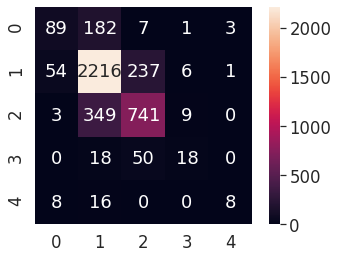

In [ ]:
# Comparison between LR (No Parameter tuning) VS LR (With Parameter tuning)

prediction_pipeline = Pipeline([
              ('lr', LogisticRegression(max_iter=3500))
              ])

prediction_pipeline.fit(train_features, train_labels)

evaluation_summary("LogisticRegression (No Parameter tuning) with TF-IDF vectorization\n", prediction_pipeline.predict(test_features), test_labels, False)

prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)),
              ('lr', LogisticRegression(solver='saga', max_iter = 5000, C = 10))
              ])

prediction_pipeline.fit(train_data, train_labels)

es = evaluation_summary("LogisticRegression (With Parameter tuning) with TF-IDF vectorization\n", prediction_pipeline.predict(test_data), test_labels, True)

tuned_lr_tfidf_test = list_builder(es)

confusion_matrix_build("LogisticRegression (With Parameter tuning) with TF-IDF vectorization\n", prediction_pipeline.predict(test_data), test_labels)

In [ ]:
# Table Comparison between LR (No Parameter tuning) VS LR (With Parameter tuning)

print("Comparison between LR (No Parameter tuning) VS LR (With Parameter tuning)")

comparison_table = PrettyTable(["Result", "Accuracy", "Precision Macro Avg", "Recall Macro Avg", "F1_Score Macro Avg", "Precision Weighted Avg", "Recall Weighted Avg", "F1_Score Weighted Avg"])
comparison_table.add_row(["LR (No Parameter tuning)",test_lr_tfidf[0],test_lr_tfidf[1],test_lr_tfidf[2],test_lr_tfidf[3],test_lr_tfidf[4],test_lr_tfidf[5],test_lr_tfidf[6]])
comparison_table.add_row([ConsoleColor.BOLD + "\033[40m \033[97m LR (With Parameter tuning)" + ConsoleColor.END,tuned_lr_tfidf_test[0],tuned_lr_tfidf_test[1],tuned_lr_tfidf_test[2],tuned_lr_tfidf_test[3],tuned_lr_tfidf_test[4],tuned_lr_tfidf_test[5],tuned_lr_tfidf_test[6]])

print(comparison_table)

Comparison between LR (No Parameter tuning) VS LR (With Parameter tuning)
+------------------------------+----------+---------------------+------------------+--------------------+------------------------+---------------------+-----------------------+
|            Result            | Accuracy | Precision Macro Avg | Recall Macro Avg | F1_Score Macro Avg | Precision Weighted Avg | Recall Weighted Avg | F1_Score Weighted Avg |
+------------------------------+----------+---------------------+------------------+--------------------+------------------------+---------------------+-----------------------+
|   LR (No Parameter tuning)   |  0.739   |        0.578        |      0.325       |       0.349        |         0.729          |        0.739        |         0.699         |
|   LR (With Parameter tuning) |  0.765   |        0.657        |      0.466       |        0.52        |         0.753          |        0.765        |         0.752         |
+------------------------------+---------

# Q3

In [ ]:
# Concatinating train and validation dataset and removing extra indexes

train_validation = pd.concat([train_data, validation_data], axis=0)
train_validation.reset_index(drop=True, inplace=True)

In [ ]:
# Using vader Sentiment, Getting Posts Labels for Train Dataset

posts_list_new_classes = []
posts_list = []
posts_list = train_validation.loc[:, "body"]
posts_list = list(posts_list)
compound = 0.1
analyzer = SentimentIntensityAnalyzer()

for i in range(len(posts_list)):
  #tokenized_sentence = spacy_tokenizer(posts_list[i])
  #string_list = ""
  #for sublist in tokenized_sentence:
    #string_list = string_list + " " + sublist

  
  vs = analyzer.polarity_scores(posts_list[i])
  for k, v in vs.items():
    if k == 'compound':
      compound = vs[k]

  if compound >= 0.7:
    posts_list_new_classes.append("very positive")

  if compound >= 0.05 and compound < 0.7:
    posts_list_new_classes.append("positive")

  if compound > -0.05 and compound < 0.05:
    posts_list_new_classes.append("neutral")

  if compound <= -0.05:
    posts_list_new_classes.append("negative")


In [ ]:
# Using vader Sentiment, Getting Posts Labels for Test Dataset

test_posts_list_new_classes = []
test_posts_list = []
test_posts_list = test_data.loc[:, "body"]
test_posts_list = list(test_posts_list)
test_compound = 0.1
analyzer = SentimentIntensityAnalyzer()

for i in range(len(test_posts_list)):
  #test_tokenized_sentence = spacy_tokenizer(test_posts_list[i])
  #test_string_list = ""
  #for test_sublist in test_tokenized_sentence:
    #test_string_list = test_string_list + " " + test_sublist

  
  test_vs = analyzer.polarity_scores(test_posts_list[i])
  for k, v in test_vs.items():
    if k == 'compound':
      test_compound = test_vs[k]

  if test_compound >= 0.7:
    test_posts_list_new_classes.append("very positive")

  if test_compound >= 0.05 and test_compound < 0.7:
    test_posts_list_new_classes.append("positive")

  if test_compound > -0.05 and test_compound < 0.05:
    test_posts_list_new_classes.append("neutral")

  if test_compound <= -0.05:
    test_posts_list_new_classes.append("negative")

In [ ]:
# Sanity Check if train classes have same number of rows like Train Data

print(len(posts_list))
print(len(posts_list_new_classes))
print(posts_list[953])
print(train_data.loc[953:953 , "sentiment.polarity"])
print(posts_list_new_classes[953])

15247
15247
That I live on the side of a volcano on a Pacific Island.
953    neutral
Name: sentiment.polarity, dtype: object
neutral


In [ ]:
# Sanity Check if test classes have same number of rows like Test Data

print(len(test_posts_list))
print(len(test_posts_list_new_classes))
print(test_posts_list[953])
print(test_data.loc[953:953 , "sentiment.polarity"])
print(test_posts_list_new_classes[953])

4016
4016
I've had this happen. I wasn't aware there was a change with the wildfire. I typically use the standard skin and have had a problem with the plants either sitting there or just periodically attacking things.
953    neutral
Name: sentiment.polarity, dtype: object
negative


In [ ]:
# Assigning Vader Labels to New column in Training Set

train_validation['new_class'] = posts_list_new_classes

In [ ]:
# Assigning Vader Labels to New column in Test Set

test_data['new_class'] = test_posts_list_new_classes

In [ ]:
# Comparing Vader Classes with Actual Labels 

comparison_column = np.where(train_validation["new_class"] == train_validation["sentiment.polarity"], True, False)
comparison_column_len = len(comparison_column)
print("Total: ", len(comparison_column))
true_count = sum(comparison_column)
print("Matching: ", true_count)
print(true_count / comparison_column_len * 100, "percentage")

Total:  15247
Matching:  6324
41.47701187118778 percentage


In [ ]:
# Creating pipeline with features union

prediction_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)), 
              ])),
            ('title', Pipeline([
              ('selector', ItemSelector(key='new_class')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)), 
              ])),
            #('majority', Pipeline([
              #('selector', ItemSelector(key='author')),
              #('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)), 
              #])),
        ])
        )
    ])

In [ ]:
# Creating train and test features using features union pipeline

new_train_features = prediction_pipeline.fit_transform(train_validation)
#new_validation_features = prediction_pipeline.transform(validation_data)
new_test_features = prediction_pipeline.transform(test_data)

print(new_train_features.shape)

(15247, 5004)


In [ ]:
# Code for using features that do not have words

new_train_features = sp.sparse.hstack([new_train_features, sp.sparse.csr.csr_matrix(train_validation["sentiment.subjectivity"]).transpose()])
new_test_features = sp.sparse.hstack([new_test_features, sp.sparse.csr.csr_matrix(test_data["sentiment.subjectivity"]).transpose()])

Evaluation for: LR Combined Model Performance on Test Data
              precision    recall  f1-score   support

           0      0.626     0.457     0.529       282
           1      0.862     0.891     0.876      2514
           2      0.749     0.764     0.757      1102
           3      0.552     0.372     0.444        86
           4      0.643     0.562     0.600        32

    accuracy                          0.812      4016
   macro avg      0.686     0.610     0.641      4016
weighted avg      0.806     0.812     0.808      4016

Evaluation for: LogisticRegression (With Parameter tuning) with TF-IDF vectorization

              precision    recall  f1-score   support

           0      0.578     0.316     0.408       282
           1      0.797     0.881     0.837      2514
           2      0.716     0.672     0.693      1102
           3      0.529     0.209     0.300        86
           4      0.667     0.250     0.364        32

    accuracy                          0.

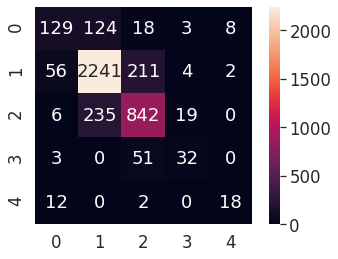

In [ ]:
# Logistic Regression Performance comparison with feature union vs without feature union

lr = LogisticRegression(solver='saga', max_iter = 5000, C = 10)
combined_model = lr.fit(new_train_features, train_validation["Class"])
evaluation_summary("LR Combined Model Performance on Test Data", lr.predict(new_test_features), test_labels, False)


prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tfidf', TfidfVectorizer(sublinear_tf = True, max_features = 5000)),
              ('lr', LogisticRegression(solver='saga', max_iter = 5000, C = 10))
              ])

prediction_pipeline.fit(train_data, train_labels)

evaluation_summary("LogisticRegression (With Parameter tuning) with TF-IDF vectorization\n", prediction_pipeline.predict(test_data), test_labels, False)

confusion_matrix_build("LR Combined Model Performance on Test Data\n", lr.predict(new_test_features), test_labels)